In [1]:
from datasets import load_dataset

dataset_name = "batterydata/pos_tagging"
training_dataset = load_dataset(dataset_name, split="train")
test_dataset = load_dataset(dataset_name, split="test")

In [2]:
# a dict containing word -> idx mapping
def create_word_indices(dataset):
    unique_words = set()
    word_to_idx = dict()
    # add an out of vocab token
    oov_token = "<OOV>"
    pad_token = "<PAD>"
    word_to_idx[oov_token] = 0
    word_to_idx[pad_token] = 1
    
    # find unique words
    for data in dataset:
        words = data["words"]
        for w in words:
            unique_words.add(w)
            
    # add index to them
    for idx, uw in enumerate(list(unique_words)):
        word_to_idx[uw] = idx + 2 # since oov is at 0 and pad at 1
        
    
    return word_to_idx


# ===============
word_to_idx = create_word_indices(training_dataset)

In [3]:
def create_label_to_idx(dataset):
    unique_labels = set()
    label_to_idx = dict()
    # add an out of vocab token
    oov_token = "<OOV>"
    pad_token = "<PAD>"
    label_to_idx[oov_token] = 0
    label_to_idx[pad_token] = 1
    
    # find the labels
    for data in dataset:
        labels = data["labels"]
        for l in labels:
            unique_labels.add(l)
            
    # index
    for idx, label in enumerate(list(unique_labels)):
        label_to_idx[label] = idx + 2
        
    return label_to_idx
    
label_to_idx = create_label_to_idx(training_dataset)

In [4]:


# for a single instance
def encode_data_instance(data, word_to_idx, label_to_idx):
    words = [
        word_to_idx.get(word, word_to_idx["<OOV>"]) for word in data["words"]
    ]
    
    labels = [
        label_to_idx[label] for label in data["labels"]
    ]
    
    return {
        "words": words,
        "labels": labels
    }
    

In [5]:
trainset = map(lambda data: encode_data_instance(data, word_to_idx, label_to_idx), training_dataset)
trainset = list(trainset)



testset = map(lambda data: encode_data_instance(
    data, word_to_idx, label_to_idx), test_dataset)
testset = list(testset)



In [6]:
# now to create the validation set
import numpy as np

def create_train_validation_splits(trainset, validation_ratio):
    validation_set_size = int(len(trainset) * validation_ratio)
    validation_indices = np.random.choice(len(trainset), replace=False, size=validation_set_size).tolist()
    
    # now to separate trainset indices
    trainset_indices = [i for i in range(len(trainset)) if i not in validation_indices]
    
    return trainset_indices, validation_indices


trainset_indices, validation_indices = create_train_validation_splits(trainset, 0.3)

print(len(trainset_indices))
print(len(validation_indices))


assert len(trainset_indices) + len(validation_indices) == len(trainset)

9138
3916


In [7]:
import torch
from torch.utils.data import Dataset

torch.manual_seed(2023)


class TagDataset(Dataset):
    def __init__(self, indices, dataset) -> None:
        self.indices = indices
        self.dataset = dataset
        
        
    def __len__(self):
        if self.indices is None:
            # this is for the test case
            return len(self.dataset)
        else:
            return len(self.indices)
        
    def __getitem__(self, index):
        if self.indices is None:
            idx = index
        else:
            idx = self.indices[index]
            
        data = self.dataset[idx]
        
        # padding to 300
        # pad token idx is 1
        words = np.ones((300, ), dtype=np.int32)
        words[:len(data["words"])] = data["words"] 
    
        
        labels = np.ones((300, ), dtype=np.int32)
        labels[:len(data["labels"])] = data["labels"]
        
        
        return torch.from_numpy(words).long(), torch.from_numpy(labels).long()

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    TagDataset(trainset_indices, trainset), batch_size=128, shuffle=True)
val_loader = DataLoader(
    TagDataset(validation_indices, trainset), batch_size=128, shuffle=False)
test_loader = DataLoader(
    TagDataset(None, testset), batch_size=128, shuffle=False)


In [9]:
# =========== test a dataloader ==========
for batch in train_loader:
    print(batch)
    break

[tensor([[12158, 14183,  7713,  ...,     1,     1,     1],
        [ 6235, 17057, 12891,  ...,     1,     1,     1],
        [24161,  4539,  7713,  ...,     1,     1,     1],
        ...,
        [21791, 23873, 12891,  ...,     1,     1,     1],
        [ 3066, 16798, 14183,  ...,     1,     1,     1],
        [16196, 17881,  5436,  ...,     1,     1,     1]]), tensor([[ 9, 16, 44,  ...,  1,  1,  1],
        [ 9,  9,  6,  ...,  1,  1,  1],
        [15, 30, 44,  ...,  1,  1,  1],
        ...,
        [30, 26,  6,  ...,  1,  1,  1],
        [29, 46, 16,  ...,  1,  1,  1],
        [30, 30, 19,  ...,  1,  1,  1]])]


In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [11]:
from tqdm.auto import trange, tqdm
from einops import rearrange

class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, embedding_dimension, projection_dims, n_labels, pad_idx) -> None:
        super().__init__()
        
        # hparams
        self.vocab_size = vocab_size
        self.embedding_dimension = embedding_dimension
        self.projection_dims = projection_dims
        self.n_labels = n_labels
        self.pad_idx = pad_idx
        
        # modules
        self.embedding = nn.Embedding(self.vocab_size, 
                                      self.embedding_dimension, 
                                      padding_idx=self.pad_idx)
        self.lstm = nn.LSTM(self.embedding_dimension, self.projection_dims, batch_first=True)        
        self.fc = nn.Linear(self.projection_dims, self.n_labels)
        
        # normal init
        self.__custom_init()
        self.embedding.weight.data[self.pad_idx] = torch.zeros(self.embedding_dimension, )
        
        self.dropout = nn.Dropout(0.2)
        
        
    def __custom_init(self):
        for p in self.parameters():
            nn.init.normal_(p.data, mean=0, std=0.1)
                
    def forward(self, x):
        out = self.embedding(x) 
        out = self.dropout(out)
        
        # this reshaping changed things. :3 Well hell pytorch
        out = rearrange(out, "batch L embed -> batch embed L")
        
        out, _ = self.lstm(out)
        out = self.fc(out)
        out = F.leaky_relu(out)
        
        
        return out
    
        
        

model = LSTMTagger(len(word_to_idx), 300, 300, 300, 1)
with torch.no_grad():
    for batch in train_loader:
        words, labels = batch
        
        logits = model(words)
        loss = F.cross_entropy(logits, labels)
        print(loss)
        break


tensor(5.8101)


  0%|          | 0/100 [00:00<?, ?it/s]

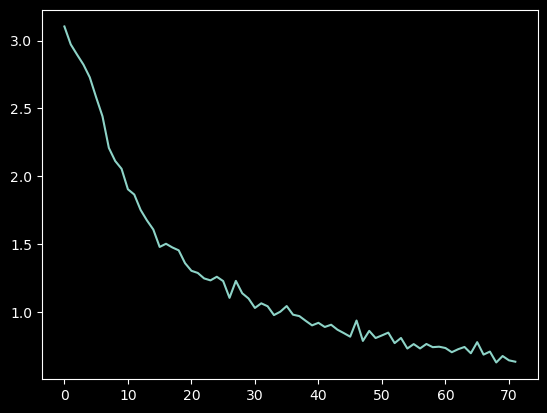

In [12]:
optimiser = optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=1)

epochs = 100

losses = list()
model = model.to("cuda")

global_steps = 0
for _ in trange(epochs):
    model.train()
    for batch in train_loader:
        words, labels = batch

        words = words.to("cuda")
        labels = labels.to("cuda")

        optimiser.zero_grad()
        logits = model(words)
        loss = criterion(logits, labels)
        
        loss.backward()
        optimiser.step()
        

        global_steps += 1

        if global_steps % 100 == 0:
            losses.append(loss.item())


%matplotlib inline 
import matplotlib.pyplot as plt

plt.plot(np.arange(len(losses)), losses)

In [13]:
# numpy, torch eq is weird
def categorical_accuracy(preds, actual):
    non_pad = np.nonzero(actual != 1)
    matches = np.equal(preds[non_pad], actual[non_pad]).sum()
    return matches / actual[non_pad].shape[0]

In [18]:
def evaluate(dataloader):
    scores = list()

    for batch in tqdm(dataloader):
        words, labels = batch
        words = words.cuda()
        
        with torch.no_grad():
            logits = model(words)
            
        logits = logits.cpu()
        probas = logits.log_softmax(dim=1)
        
        preds = probas.argmax(dim=1)
        
        acc = categorical_accuracy(preds.numpy(), labels.numpy())
        scores.append(acc)
        
        
    print(torch.tensor(scores).mean(dim=-1))
    

# ================
evaluate(train_loader)
evaluate(val_loader)
evaluate(test_loader)

Weird enough, the same model trains and generalises properly with flax but is bad with torch. What's wrong here? Param init? And I trained the flax version for 5 epochs only. :3 

Parameter initilisation is my first suspect. Flax inits params differently. The Dropout may not make much of a diff. 

**Update post debug**

You have to reshape embedding inputs to the LSTM. 
(I wonder who designed this weird API)
